In [1]:
import pandas as pd

In [2]:
df_data = pd.read_csv('finall_mbti_data.csv', encoding='utf-8')

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390399 entries, 0 to 390398
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  390399 non-null  int64 
 1   text        390242 non-null  object
 2   type        390399 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.9+ MB


In [4]:
df_data = df_data.dropna(axis=0)

In [5]:
df_data.drop(['Unnamed: 0'], axis=1, inplace=True )

In [6]:
# text 칼럼 내용만 list에 저장
dataList = list(df_data['text'])

In [7]:
# 토크나이징을 위해 list를 string으로 변환
dataStr = '@#'.join(s for s in dataList)

In [8]:
import re
# 정규표현식을 이용해서 완전한 한글, 숫자 띄어쓰기를 제외한 모든 부분 제거

hangul = re.compile('[^ ㅋㅎ@#가-힣0-9a-z+]')
dataRe = hangul.sub('', dataStr) 

In [9]:
# 전처리한 데이터를 사전에 지정해둔 지정자 @#로 split후 리스트로 저장
dataClean = dataRe.split('@#')

In [10]:
len(dataClean)

390242

In [11]:
# 기존 데이터프레임에 text내용 변경
df_data["text"] = dataClean

In [12]:
train_df = df_data.sample(frac=0.9, random_state=2022).sort_index()
test_df = df_data.drop(train_df.index)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351218 entries, 0 to 390398
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    351218 non-null  object
 1   type    351218 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.0+ MB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39024 entries, 6 to 390380
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39024 non-null  object
 1   type    39024 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 914.6+ KB


### 토큰분리

In [15]:
from konlpy.tag import Okt
okt = Okt()

[0.002s][warning][os,thread] Attempt to protect stack guard pages failed (0x000000016d970000-0x000000016d97c000).
[0.002s][warning][os,thread] Attempt to deallocate stack guard pages failed.


In [16]:
def ko_tokenize(text, pos=['Noun', 'Verb', 'Adjective', 'Adverb', 'Exclamation', 'Unknown', 'KoreanParticle']):
    return [morph for morph, tag in okt.pos(text) if tag in pos]

In [17]:
train_text, test_text = [], []
for sent1 in train_df['text']:
    train_text.append(ko_tokenize(sent1))
for sent2 in test_df['text']:
    test_text.append(ko_tokenize(sent2))
    
        
print(train_text[:3])
print(test_text[:3])

[['프제', '남자', '연락', '하는데'], ['내', '하고', '있는걸', '까'], ['아무리', '봐도', '친구사이']]
[['소개팅', '했는데', '잘', '안', '됐어'], ['슬퍼'], ['년', '주기', '심심할', '때', '검사', '하는데', '신기하네']]


In [18]:
# 학습 데이터 각 토큰에 정수 인덱스 할당, 빈도 카운트

from tensorflow.keras.preprocessing.text import Tokenizer
tok = Tokenizer()
tok.fit_on_texts(train_text) # 어휘 업데이트. 입력: 토큰 (리스트의) 리스트

Init Plugin
Init Graph Optimizer
Init Kernel


In [19]:
len(tok.word_index)

104408

In [20]:
# 각 단어와 출현 빈도 (단어 -> 빈도)
tok.word_counts

OrderedDict([('프제', 17453),
             ('남자', 4614),
             ('연락', 2619),
             ('하는데', 1336),
             ('내', 8366),
             ('하고', 908),
             ('있는걸', 51),
             ('까', 1016),
             ('아무리', 226),
             ('봐도', 321),
             ('친구사이', 28),
             ('거', 7050),
             ('호감', 1742),
             ('표현', 494),
             ('바람', 291),
             ('펴', 20),
             ('본적', 502),
             ('있거나', 22),
             ('끌려', 45),
             ('있음', 1990),
             ('여자', 5075),
             ('모르겠고', 52),
             ('자기', 1582),
             ('좋아하는지', 43),
             ('헷갈린다면', 4),
             ('남사', 234),
             ('친', 794),
             ('스며들거', 1),
             ('같아', 1620),
             ('너', 4343),
             ('상대', 709),
             ('는', 2748),
             ('어떻게', 4501),
             ('아는거냐', 2),
             ('녀', 1202),
             ('밥', 782),
             ('먹는다', 42),
             ('전남친', 266

In [21]:
# 출현 빈도(1~5)별 단어 개수 확인
counts = [len(tok.word_index), 0, 0, 0, 0, 0]
for key, freq in tok.word_counts.items():
    if freq <= 5:
        counts[freq] = counts[freq] + 1
counts

[104408, 60973, 13438, 6368, 3910, 2628]

In [22]:
count2 = counts[0] - counts[1]
print(f'2회 이상 출현한 단어 개수: {count2}')
count3 = count2 - counts[2]
print(f'3회 이상 출현한 단어 개수: {count3}')

2회 이상 출현한 단어 개수: 43435
3회 이상 출현한 단어 개수: 29997


In [23]:
vocab_size = count3 + 1
tok = Tokenizer(vocab_size, oov_token='OOV')
tok.fit_on_texts(train_text)

In [24]:
len(tok.word_index)

104409

In [25]:
# 학습 데이터 각 토큰의 정수 인덱스를 사용하여 학습/테스트 데이터 정수 인코딩
X_train = tok.texts_to_sequences(train_text)
y_train = train_df['type'].values
X_test = tok.texts_to_sequences(test_text)
y_test = test_df['type'].values
X_train[:3]

[[2, 25, 57, 132], [6, 204, 3086, 182], [985, 693, 4994]]

In [26]:
# 구성 단어가 하나도 없는 샘플 삭제
import numpy as np
empty_samples = [i for i, x in enumerate(X_train) if len(x) < 1] # 삭제할 샘플 인덱스
len(empty_samples)

6832

In [27]:
X_train = np.delete(X_train, empty_samples, axis=0)
y_train = np.delete(y_train, empty_samples, axis=0)
print(len(X_train))
print(len(X_train), len(y_train))

344386
344386 344386


/opt/homebrew/Caskroom/miniforge/base/envs/tmclass/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [28]:
# 학습 데이터 샘플의 최대 길이 확인
max(len(x) for x in X_train)

320

In [29]:
# X의 샘플들 중 길이가 leng 이하인 샘플 개수의 비율
def ratio_of_samples_shorter_than_equal(leng, X):
    count = 0
    for x in X:
        if (len(x) <= leng):
            count = count + 1
    return count / len(X) * 100

In [30]:
ratio_of_samples_shorter_than_equal(20, X_train)

99.90040245538437

In [31]:
ratio_of_samples_shorter_than_equal(10, X_train)

98.47816113314711

In [32]:
ratio_of_samples_shorter_than_equal(7, X_train)

90.89335803429873

In [33]:
max_len = 10

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [35]:
X_train = X_train.astype(np.int64)
X_test = X_test.astype(np.int64)

## 임베딩(Word2Vex모델사용)

In [36]:
import gensim

In [37]:
model_kr = gensim.models.Word2Vec.load("ko.bin")
model_kr.wv.save_word2vec_format("ko.bin.gz", binary=False)

In [38]:
NUM_WORDS, EMB_DIM = model_kr.wv.vectors.shape
vocab_size = NUM_WORDS

### 순환 신경망모델

Metal device set to: Apple M1 Pro


2022-06-16 06:14:30.031448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-16 06:14:30.031551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-16 06:14:30.633550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-16 06:14:30.633718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-06-16 06:14:38.357282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:14:38.423413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:14:38.500722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2756/2756 [==============================] - ETA: 0s - loss: 2.0924 - accuracy: 0.3357

2022-06-16 06:15:15.355436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:15:15.386201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2756/2756 [==============================] - 50s 15ms/step - loss: 2.0923 - accuracy: 0.3357 - val_loss: 2.6326 - val_accuracy: 0.1286
Epoch 2/20
2756/2756 [==============================] - 42s 15ms/step - loss: 1.8220 - accuracy: 0.4132 - val_loss: 2.6623 - val_accuracy: 0.1317
Epoch 3/20
2756/2756 [==============================] - 42s 15ms/step - loss: 1.7630 - accuracy: 0.4306 - val_loss: 2.6483 - val_accuracy: 0.1348
Epoch 4/20
2756/2756 [==============================] - 42s 15ms/step - loss: 1.7154 - accuracy: 0.4465 - val_loss: 2.6839 - val_accuracy: 0.1338
Epoch 00004: early stopping


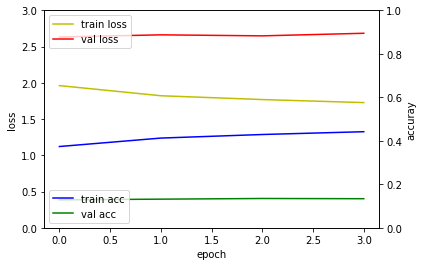

In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = EMB_DIM # 임베딩 차원

model1 = Sequential()
#model1.add(Embedding(30185, 128, input_length=max_len))
e = Embedding(vocab_size, embedding_dim, weights=[model_kr.wv.vectors], input_length=max_len, trainable=False)
model1.add(e)
model1.add(LSTM(128))
model1.add(Dense(16, activation='softmax'))  # 카테고리 수

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm1_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model1.fit(X_train, y_train, batch_size=100, epochs=20, validation_split=0.2, callbacks=[es,mc])

model1.save("lstm_yu.h5")

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()



In [40]:
# 모델 평가하기
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

610/610 [==============================] - 5s 8ms/step - loss: 2.0082 - accuracy: 0.3538
## evaluation loss and_metrics ##
[2.0082411766052246, 0.35383355617523193]


### 컨볼루션 신경망모델

Epoch 1/20
  12/2756 [..............................] - ETA: 26s - loss: 4.2331 - accuracy: 0.0908 

2022-06-16 06:17:34.320216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2755/2756 [============================>.] - ETA: 0s - loss: 2.2451 - accuracy: 0.2865

2022-06-16 06:17:57.274248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2756/2756 [==============================] - 28s 10ms/step - loss: 2.2450 - accuracy: 0.2865 - val_loss: 2.5908 - val_accuracy: 0.1246
Epoch 2/20
2756/2756 [==============================] - 27s 10ms/step - loss: 1.9535 - accuracy: 0.3635 - val_loss: 2.5795 - val_accuracy: 0.1157
Epoch 3/20
2756/2756 [==============================] - 27s 10ms/step - loss: 1.9106 - accuracy: 0.3768 - val_loss: 2.5652 - val_accuracy: 0.1281
Epoch 4/20
2756/2756 [==============================] - 27s 10ms/step - loss: 1.8906 - accuracy: 0.3822 - val_loss: 2.5759 - val_accuracy: 0.1235
Epoch 5/20
2756/2756 [==============================] - 27s 10ms/step - loss: 1.8749 - accuracy: 0.3886 - val_loss: 2.6002 - val_accuracy: 0.1061
Epoch 6/20
2756/2756 [==============================] - 27s 10ms/step - loss: 1.8630 - accuracy: 0.3907 - val_loss: 2.5819 - val_accuracy: 0.1360
Epoch 00006: early stopping


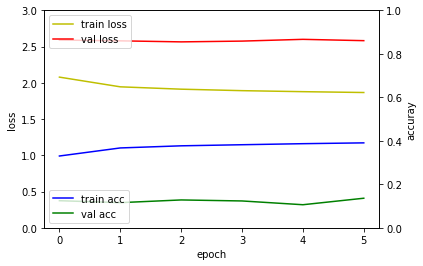

In [41]:
from keras.layers import Flatten, Dropout, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = EMB_DIM # 임베딩 차원


model2 = Sequential()
e = Embedding(vocab_size, embedding_dim, weights=[model_kr.wv.vectors], input_length=max_len, trainable=False)
model2.add(e)
model2.add(Dropout(0.2))
model2.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm2_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model2.fit(X_train, y_train, batch_size=100, epochs=20, validation_split=0.2, callbacks=[es,mc])

# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [42]:
# 모델 평가하기
loss_and_metrics = model2.evaluate(X_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

610/610 [==============================] - 4s 6ms/step - loss: 2.0015 - accuracy: 0.3446
## evaluation loss and_metrics ##
[2.001509666442871, 0.344634085893631]


### 순환 컨볼루션 신경망 모델

Epoch 1/20
   1/2756 [..............................] - ETA: 1:04:39 - loss: 2.7685 - accuracy: 0.1000

2022-06-16 06:20:21.832819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:20:21.909637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:20:21.960317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2755/2756 [============================>.] - ETA: 0s - loss: 2.1815 - accuracy: 0.2999

2022-06-16 06:20:57.145676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:20:57.184669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2756/2756 [==============================] - 42s 15ms/step - loss: 2.1814 - accuracy: 0.3000 - val_loss: 2.5295 - val_accuracy: 0.1529
Epoch 2/20
2756/2756 [==============================] - 40s 15ms/step - loss: 1.9487 - accuracy: 0.3703 - val_loss: 2.5636 - val_accuracy: 0.1507
Epoch 3/20
2756/2756 [==============================] - 40s 14ms/step - loss: 1.9347 - accuracy: 0.3759 - val_loss: 2.5951 - val_accuracy: 0.1365
Epoch 4/20
2756/2756 [==============================] - 40s 15ms/step - loss: 1.9317 - accuracy: 0.3755 - val_loss: 2.6282 - val_accuracy: 0.1219
Epoch 00004: early stopping


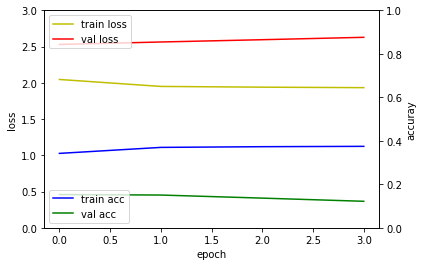

In [43]:
from keras.layers import Flatten, Dropout, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = EMB_DIM # 임베딩 차원

model3 = Sequential()
e = Embedding(vocab_size, embedding_dim, weights=[model_kr.wv.vectors], input_length=max_len, trainable=False)
model3.add(e)
model3.add(Dropout(0.2))
model3.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model3.add(MaxPooling1D(pool_size=4))
model3.add(LSTM(128))
model3.add(Dense(16, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm3_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model3.fit(X_train, y_train, batch_size=100, epochs=20,validation_split=0.2, callbacks=[es,mc])

# 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [44]:
# 모델 평가하기
loss_and_metrics = model3.evaluate(X_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

610/610 [==============================] - 5s 8ms/step - loss: 2.0638 - accuracy: 0.3225
## evaluation loss and_metrics ##
[2.0638208389282227, 0.3225451111793518]


### 다중 레이블 신경망 모델

Epoch 1/20
 14/539 [..............................] - ETA: 4s - loss: 860.6457 - accuracy: 0.0700  

2022-06-16 06:23:08.745318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


539/539 [==============================] - ETA: 0s - loss: 202.7820 - accuracy: 0.0759

2022-06-16 06:23:13.506890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


539/539 [==============================] - 6s 10ms/step - loss: 202.6011 - accuracy: 0.0759 - val_loss: 80.2247 - val_accuracy: 0.1194
Epoch 2/20
539/539 [==============================] - 5s 10ms/step - loss: 46.3123 - accuracy: 0.0807 - val_loss: 43.2258 - val_accuracy: 0.1639
Epoch 3/20
539/539 [==============================] - 5s 10ms/step - loss: 29.0007 - accuracy: 0.0848 - val_loss: 46.8229 - val_accuracy: 0.0871
Epoch 4/20
539/539 [==============================] - 5s 9ms/step - loss: 18.7234 - accuracy: 0.0885 - val_loss: 17.6608 - val_accuracy: 0.0805
Epoch 5/20
539/539 [==============================] - 5s 9ms/step - loss: 9.0424 - accuracy: 0.0824 - val_loss: 5.6466 - val_accuracy: 0.1024
Epoch 6/20
539/539 [==============================] - 5s 9ms/step - loss: 2.9897 - accuracy: 0.0770 - val_loss: 4.7128 - val_accuracy: 0.0962
Epoch 7/20
539/539 [==============================] - 5s 10ms/step - loss: 2.7223 - accuracy: 0.0977 - val_loss: 2.6080 - val_accuracy: 0.1237
Epoc

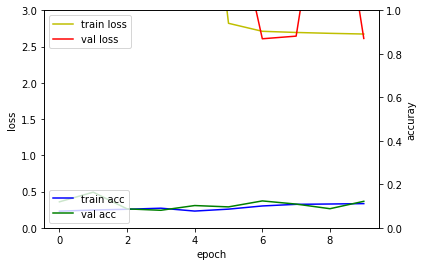

In [45]:
from keras import models
from keras import layers
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model4 = models.Sequential()
model4.add(layers.Dense(64, activation='relu', input_shape=(max_len,)))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(16, activation='softmax'))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('lstm4_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



history = model4.fit(X_train, y_train, batch_size=512, epochs=20, validation_split=0.2, callbacks=[es,mc])

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [46]:
def sentence1(sentence):
    sample = tok.texts_to_sequences(sentence)
    sample = pad_sequences(sample, maxlen=max_len)
    predictions = model1.predict(sample)
    score = np.argmax(predictions[0])
    if (score == 0):
        print("enfj입니다.")
    elif (score == 1):
        print("entj입니다.")
    elif (score == 2):
        print("estj입니다.")
    elif (score == 3):
        print("esfj입니다.")
    elif (score == 4):
        print("entp입니다.")
    elif (score == 5):
        print("enfp입니다.")
    elif (score == 6):
        print("estp입니다.")
    elif (score == 7):
        print("esfp입니다.")
    elif (score == 8):
        print("istj입니다.")
    elif (score == 9):
        print("isfj입니다.")
    elif (score == 10):
        print("infj입니다.")
    elif (score == 11):
        print("intj입니다.")
    elif (score == 12):
        print("istp입니다.")
    elif (score == 13):
        print("isfp입니다.")
    elif (score == 14):
        print("infp입니다.")    
    else:
        print("intp입니다.") 

In [47]:
def sentence2(sentence):
    sample = tok.texts_to_sequences(sentence)
    sample = pad_sequences(sample, maxlen=max_len)
    predictions = model2.predict(sample)
    score = np.argmax(predictions[0])
    if (score == 0):
        print("enfj입니다.")
    elif (score == 1):
        print("entj입니다.")
    elif (score == 2):
        print("estj입니다.")
    elif (score == 3):
        print("esfj입니다.")
    elif (score == 4):
        print("entp입니다.")
    elif (score == 5):
        print("enfp입니다.")
    elif (score == 6):
        print("estp입니다.")
    elif (score == 7):
        print("esfp입니다.")
    elif (score == 8):
        print("istj입니다.")
    elif (score == 9):
        print("isfj입니다.")
    elif (score == 10):
        print("infj입니다.")
    elif (score == 11):
        print("intj입니다.")
    elif (score == 12):
        print("istp입니다.")
    elif (score == 13):
        print("isfp입니다.")
    elif (score == 14):
        print("infp입니다.")    
    else:
        print("intp입니다.") 

In [48]:
def sentence3(sentence):
    sample = tok.texts_to_sequences(sentence)
    sample = pad_sequences(sample, maxlen=max_len)
    predictions = model3.predict(sample)
    score = np.argmax(predictions[0])
    if (score == 0):
        print("enfj입니다.")
    elif (score == 1):
        print("entj입니다.")
    elif (score == 2):
        print("estj입니다.")
    elif (score == 3):
        print("esfj입니다.")
    elif (score == 4):
        print("entp입니다.")
    elif (score == 5):
        print("enfp입니다.")
    elif (score == 6):
        print("estp입니다.")
    elif (score == 7):
        print("esfp입니다.")
    elif (score == 8):
        print("istj입니다.")
    elif (score == 9):
        print("isfj입니다.")
    elif (score == 10):
        print("infj입니다.")
    elif (score == 11):
        print("intj입니다.")
    elif (score == 12):
        print("istp입니다.")
    elif (score == 13):
        print("isfp입니다.")
    elif (score == 14):
        print("infp입니다.")    
    else:
        print("intp입니다.") 

In [49]:
def sentence4(sentence):
    sample = tok.texts_to_sequences(sentence)
    sample = pad_sequences(sample, maxlen=max_len)
    predictions = model3.predict(sample)
    score = np.argmax(predictions[0])
    if (score == 0):
        print("enfj입니다.")
    elif (score == 1):
        print("entj입니다.")
    elif (score == 2):
        print("estj입니다.")
    elif (score == 3):
        print("esfj입니다.")
    elif (score == 4):
        print("entp입니다.")
    elif (score == 5):
        print("enfp입니다.")
    elif (score == 6):
        print("estp입니다.")
    elif (score == 7):
        print("esfp입니다.")
    elif (score == 8):
        print("istj입니다.")
    elif (score == 9):
        print("isfj입니다.")
    elif (score == 10):
        print("infj입니다.")
    elif (score == 11):
        print("intj입니다.")
    elif (score == 12):
        print("istp입니다.")
    elif (score == 13):
        print("isfp입니다.")
    elif (score == 14):
        print("infp입니다.")    
    else:
        print("intp입니다.") 

### 순환신경망

In [50]:
sentence1('워터밤 축제는 사람도 많고 그냥 계곡에서 혼자 발 담구고 놀거야')

entp입니다.


2022-06-16 06:23:59.578960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:23:59.602766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [51]:
sentence1('백두산 화산이 폭발하면 제주도에 있으면 살 수 있을까?')

entp입니다.


In [52]:
sentence1('시험은 벼락치기가 짱이지')

esfp입니다.


In [53]:
sentence1('내가 뭔상관이야')

istp입니다.


### 컨볼루션 신경망

In [54]:
sentence2('워터밤 축제는 사람도 많고 그냥 계곡에서 혼자 발 담구고 놀거야')

istp입니다.


2022-06-16 06:24:00.439434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [55]:
sentence2('백두산 화산이 폭발하면 제주도에 있으면 살 수 있을까?')

istp입니다.


In [56]:
sentence2('시험은 벼락치기가 짱이지')

entp입니다.


In [57]:
sentence2('내가 뭔상관이야')

entp입니다.


### 순환 컨볼루션 신경망

In [58]:
sentence3('워터밤 축제는 사람도 많고 그냥 계곡에서 혼자 발 담구고 놀거야')

isfp입니다.


2022-06-16 06:24:01.812404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-16 06:24:01.840825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [59]:
sentence3('백두산 화산이 폭발하면 제주도에 있으면 살 수 있을까?')

istp입니다.


In [60]:
sentence3('시험은 벼락치기가 짱이지')

estp입니다.


In [61]:
sentence3('내가 뭔상관이야')

istp입니다.


### 그냥 신경망 (임베딩 적용X)

In [62]:
sentence4('워터밤 축제는 사람도 많고 그냥 계곡에서 혼자 발 담구고 놀거야')

isfp입니다.


In [63]:
sentence4('백두산 화산이 폭발하면 제주도에 있으면 살 수 있을까?')

istp입니다.


In [64]:
sentence4('시험은 벼락치기가 짱이지')

estp입니다.


In [65]:
sentence4('내가 뭔상관이야')

istp입니다.
